71.28	70.89	74.76	73.98
66.30	66.00	69.08	68.28
2025-12-05_21-33-27.png


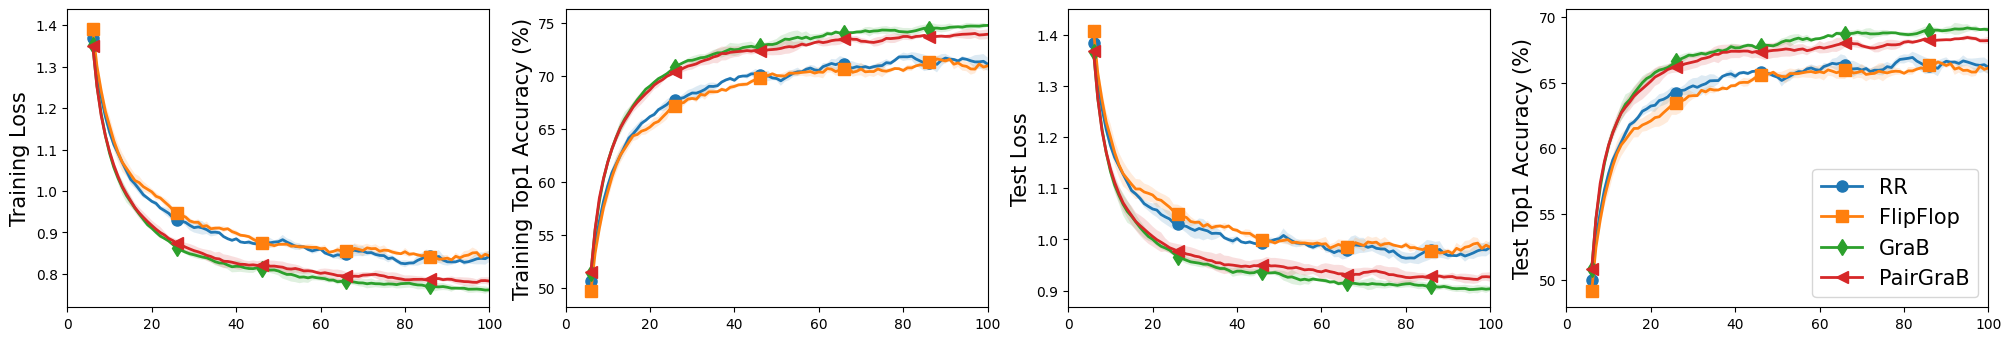

In [5]:
'''
There are two options to smooth the data.
(1) smooth the original data.
(2) smooth the mean and std of the original data.

To the best of our known, both are correct. We use option (1).
'''

'''
Formal version 2: Add seeds_patterns.
'''


import sys 
sys.path.append("/home/moon/data/github/ordering/")

import numpy as np
import os
import re
import matplotlib as mpl
import matplotlib.pyplot as plt

from sim.utils.record_utils import read_fromcsv
from plots.plot_utils import moving_average, save_fig_timestamp, MARKERS

def plot_mean(ax, patterns, seeds_patterns, setup, path='save/quadratic/'):
    labels = setup['labels']
    ylabels = ['Round', 'Training Loss', 'Training Top1 Accuracy (%)', 'Training Top5 Accuracy (%)', 'Test Loss', 'Test Top1 Accuracy (%)', 'Test Top5 Accuracy (%)']
    col = setup['col']
    start = setup['start']
    end = setup['end']
    select = setup['select']

    lines = []
    for i in range(len(patterns)):
        error_seeds = []
        for seed in seeds_patterns[i]:
            file = re.sub(r'seed\d+', 'seed{}'.format(seed), patterns[i])
            file = f'{file}.csv' if '.csv' not in file else file
            if os.path.exists(os.path.join(path, file)):
                df = read_fromcsv(file, path)
            else:
                print("Not found {}".format(os.path.join(path, file)))
            error = df.iloc[:, col].values # get the param error and order error
            error_seeds.append(error.tolist())
        error_seeds = np.vstack(error_seeds)

        x = df.iloc[:, 0].values # round
        y = error_seeds

        if setup['report']:
            if col in [2,5]:
                print_end = '\n' if i == len(patterns)-1 else '\t'
                position = np.where(x == end)[0][0]
                print("{:.2f}".format(y.mean(axis=0)[position+1-select:position+1].mean()), end=print_end)
        
        # Option 1
        if setup['smooth']:
            window_size = 6
            y_smooth = np.array([moving_average(y_seed, window_size) for y_seed in y])
            # adjust the length of the smooth data
            # discard `len(data)- (len(data)-len(windows)+1)=len(windows)-1` data points
            x_smooth = x[len(x)-len(y_smooth[0]):]
            # back to the original variable
            x, y = x_smooth, y_smooth
        y_mean = y.mean(axis=0); y_std = y.std(axis=0)
        
        # Option 2
        # y_mean = y.mean(axis=0); y_std = y.std(axis=0)
        # if setup['smooth']:
        #     window_size = 3
        #     mean_smooth = moving_average(y_mean, window_size)
        #     std_smooth = moving_average(y_std, window_size)
        #     x_smooth = x[len(x)-len(mean_smooth):]
        #     # back to the original variable
        #     x, y_mean, y_std = x_smooth, mean_smooth, std_smooth

        line, = ax.plot(x, y_mean, linestyle='-', color="C{}".format(i), lw=2, label=labels[i], marker=MARKERS[i], markersize=8, markevery=20)
        #line, = ax.plot(x, y_mean, linestyle='-', color="C{}".format(i), lw=2.5, label=labels[i])
        #plt.fill_between(x_axis, FedAvgdata[i].mean(axis=0) - FedAvgdata[i].std(axis=0), FedAvgdata[i].mean(axis=0) +FedAvgdata[i].std(axis=0), facecolor=colors[i], alpha=0.25) 
        fill = ax.fill_between(x, y_mean-y_std, y_mean+y_std, facecolor="C{}".format(i), alpha=0.15)
        lines.append(line)

    #ax.set_yscale('log')
    ax.set_ylabel(ylabels[col], fontsize=15)
    ax.set_xlim(xmin=0, xmax=end)
    return lines

def main():
    #global path, lrs, seeds, args
    path = f"/home/moon/data/github/ordering/save/"
    seeds_patterns = [[0,1,2], [0,1,2], [0,1,2], [0,1,2]]
    #seeds_patterns = [[0,1,2,3,4], [0,1,2,3,4], [0,1,2,3,4], [0,1,2,3,4], [0,1,2,3,4], [0,1,2,3,4]]

    patterns = [

"sgd2/RR_R100,1_lenet5_cifar10_sgd0.001,0.9,0.01_exp1.0_b8,2_seed0_clip0.csv",
"sgd2/FlipFlop_R100,1_lenet5_cifar10_sgd0.001,0.9,0.01_exp1.0_b8,2_seed0_clip0.csv",
"sgd2/GraB_R100,1_lenet5_cifar10_sgd0.001,0.9,0.01_exp1.0_b8,2_seed0_clip0.csv",
"sgd2/PairGraB_R100,1_lenet5_cifar10_sgd0.001,0.9,0.01_exp1.0_b8,2_seed0_clip0.csv",

    ]
    s = ""

    s = "RR, FlipFlop, GraB, PairGraB"
    if s != "":
        labels = [item.strip() for item in s.split(",")]

    fig, axes = plt.subplots(1, 4, figsize=(20, 3.3), constrained_layout=True)
    for i in range(4):
        lines = plot_mean(axes[i], patterns = patterns, seeds_patterns=seeds_patterns, setup={'start': 1, 'end': 100, 'col': [1,2,4,5][i], 'smooth': 1, 'report': 1, 'select': 10, 'labels': labels}, path=path)
    
    #fig.legend(handles=lines, labels=labels, loc='upper center', ncols=len(patterns), bbox_to_anchor=(0.5, 1.18), fontsize=16)
    #axes[3].set_ylim(ymin=20)
    axes[3].legend(fontsize=15)
    
    save_fig_timestamp(fig)

if __name__ == '__main__':
    main()
